## Import Data

In [215]:
import os
dataset_path = r'C:\Users\Fathan Askar\Downloads\DatasetViskom\DatasetViskom'
file_list = os.listdir(dataset_path)
print(file_list)

['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']


In [216]:
# %pip install --upgrade tensorflow

## Import Functions

In [217]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
import seaborn as sns

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import Model
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.layers import Normalization
from tensorflow.keras.layers import CenterCrop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

# System libraries
from pathlib import Path
import os.path
import requests

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

sns.set_style('darkgrid')

In [218]:
def seed_everything(seed=42):
    # Set seed for TensorFlow
    tf.random.set_seed(seed)

    # Set seed for NumPy
    np.random.seed(seed)

    # Set seed for Python's random library
    random.seed(seed)

    # Set environment variable for reproducibility across systems
    os.environ['PYTHONHASHSEED'] = str(seed)

    # Ensure deterministic behavior for TensorFlow
    # This might not guarantee full reproducibility but helps
    tf.config.threading.set_intra_op_parallelism_threads(1)
    tf.config.threading.set_inter_op_parallelism_threads(1)

seed_everything()

In [219]:
# URL of the file you want to download
url = 'https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py'

# Send a GET request to the URL
response = requests.get(url)

# Write the content of the response (the file) to a local file
with open('helper_functions.py', 'wb') as file:
    file.write(response.content)

# Now you can import the functions from the downloaded file
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot


In [220]:
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

In [221]:
dataset = dataset_path
walk_through_dir(dataset)

There are 10 directories and 0 images in 'C:\Users\Fathan Askar\Downloads\DatasetViskom\DatasetViskom'.
There are 0 directories and 2112 images in 'C:\Users\Fathan Askar\Downloads\DatasetViskom\DatasetViskom\butterfly'.
There are 0 directories and 1668 images in 'C:\Users\Fathan Askar\Downloads\DatasetViskom\DatasetViskom\cat'.
There are 0 directories and 3098 images in 'C:\Users\Fathan Askar\Downloads\DatasetViskom\DatasetViskom\chicken'.
There are 0 directories and 1866 images in 'C:\Users\Fathan Askar\Downloads\DatasetViskom\DatasetViskom\cow'.
There are 0 directories and 4863 images in 'C:\Users\Fathan Askar\Downloads\DatasetViskom\DatasetViskom\dog'.
There are 0 directories and 1446 images in 'C:\Users\Fathan Askar\Downloads\DatasetViskom\DatasetViskom\elephant'.
There are 0 directories and 2623 images in 'C:\Users\Fathan Askar\Downloads\DatasetViskom\DatasetViskom\horse'.
There are 0 directories and 1820 images in 'C:\Users\Fathan Askar\Downloads\DatasetViskom\DatasetViskom\sheep

In [222]:
def convert_path_to_df(dataset):
    image_dir = Path(dataset)

    # Get filepaths and labels
    filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.jpeg')) + list(image_dir.glob(r'**/*.PNG'))

    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    image_df = pd.concat([filepaths, labels], axis=1)
    return image_df

image_df = convert_path_to_df(dataset)

C:\Users\Fathan Askar\AppData\Local\Temp\ipykernel_21556\1586375685.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, hue=None, alpha=0.8, palette='pastel', ax=axes)


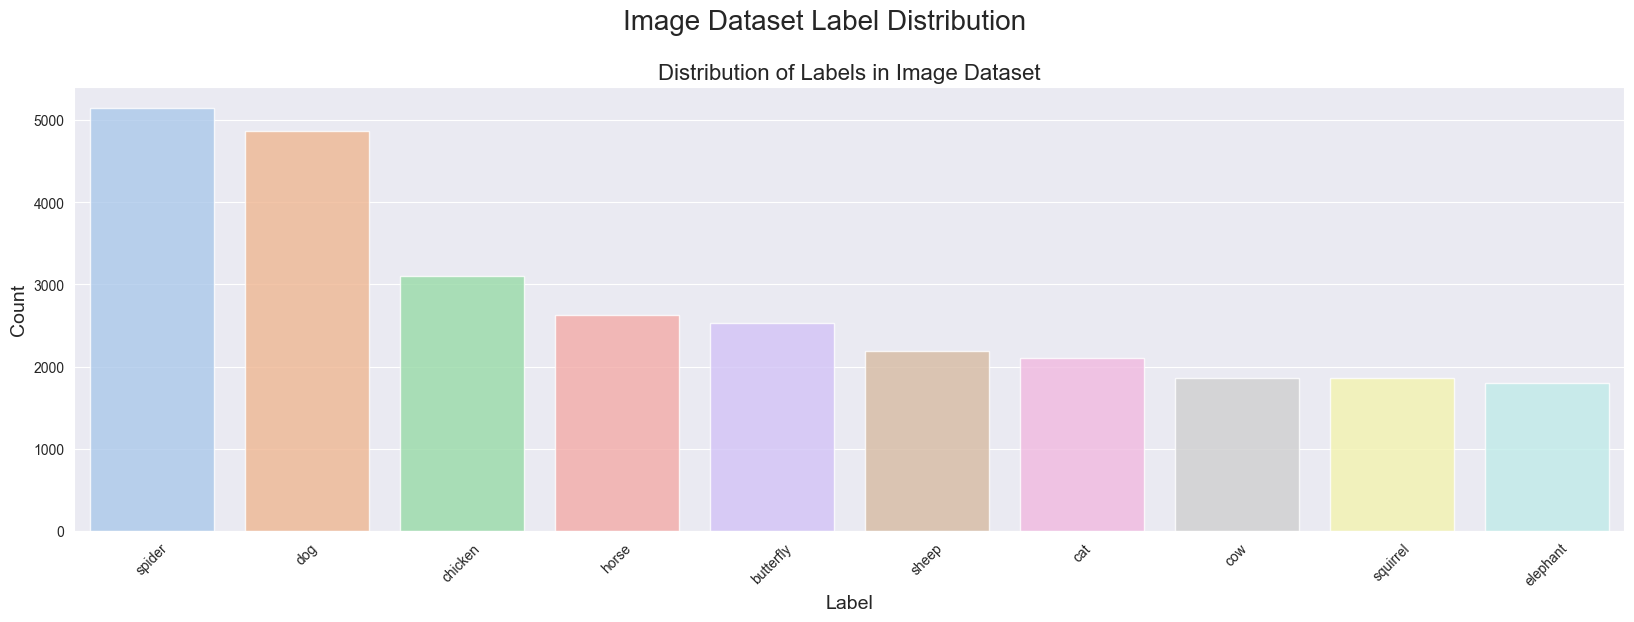

In [223]:
# Get the value counts for each label
label_counts = image_df['Label'].value_counts()

# Create the figure and axes
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 6))

# Plot the bar chart
sns.barplot(x=label_counts.index, y=label_counts.values, hue=None, alpha=0.8, palette='pastel', ax=axes)
axes.set_title('Distribution of Labels in Image Dataset', fontsize=16)
axes.set_xlabel('Label', fontsize=14)
axes.set_ylabel('Count', fontsize=14)

# Set x-ticks and labels
axes.set_xticks(range(len(label_counts.index)))
axes.set_xticklabels(label_counts.index, rotation=45)

# Add a super-title to the figure
fig.suptitle('Image Dataset Label Distribution', fontsize=20)

# Adjust the spacing between the plots and the title
fig.subplots_adjust(top=0.85)

# Display the plot
plt.show()


C:\Users\Fathan Askar\AppData\Local\Temp\ipykernel_21556\3646252627.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts_limited.index, y=label_counts_limited.values, hue=None, alpha=0.8, palette='pastel', ax=axes)


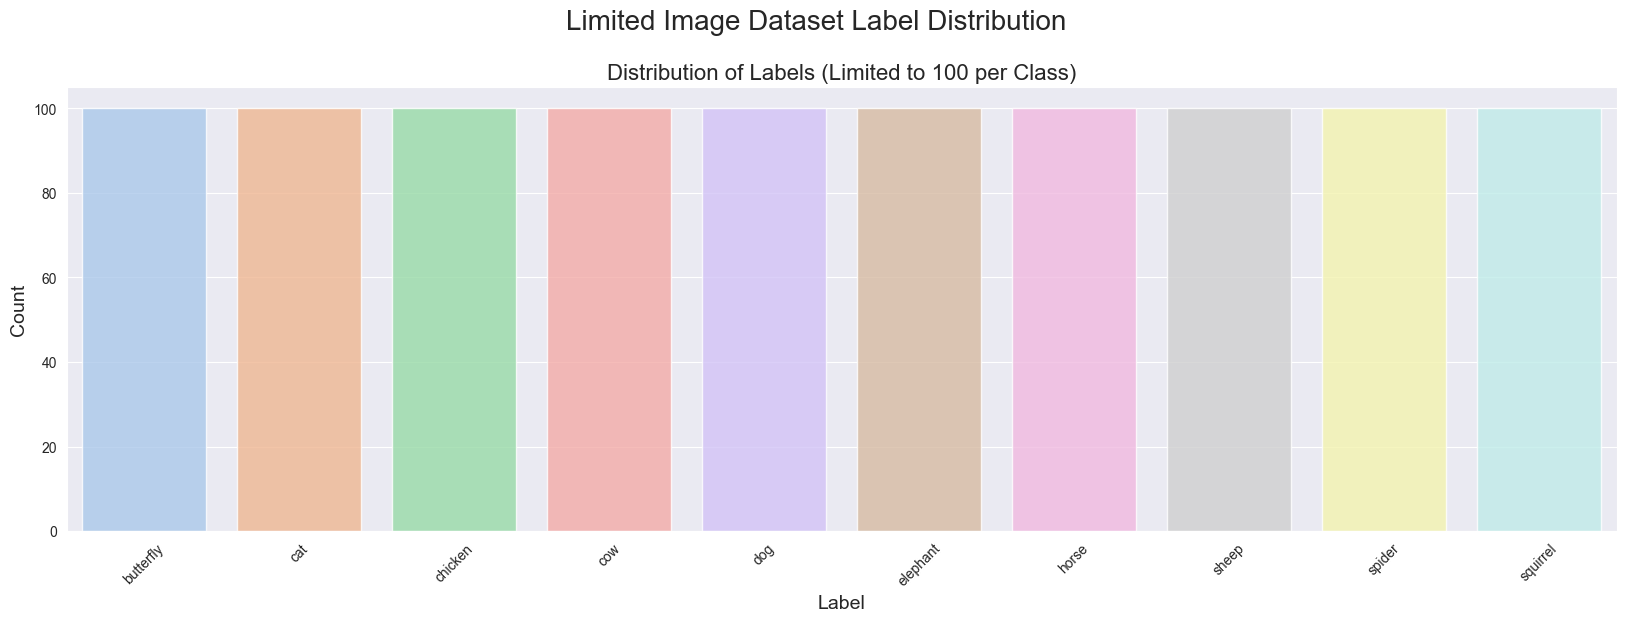

In [224]:
# Limit the number of images to 100 per class
def limit_images_per_class(image_df, num_images=100):
    # Group by label and sample 100 images per class
    image_df_limited = image_df.groupby('Label').apply(lambda x: x.sample(min(len(x), num_images), random_state=42)).reset_index(drop=True)
    return image_df_limited

# Apply the function to limit each class to 100 images
image_df_limited = limit_images_per_class(image_df, num_images=100)

# Check the distribution after limiting to 100 images per class
label_counts_limited = image_df_limited['Label'].value_counts()

# Plot the updated distribution
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 6))

sns.barplot(x=label_counts_limited.index, y=label_counts_limited.values, hue=None, alpha=0.8, palette='pastel', ax=axes)
axes.set_title('Distribution of Labels (Limited to 100 per Class)', fontsize=16)
axes.set_xlabel('Label', fontsize=14)
axes.set_ylabel('Count', fontsize=14)

axes.set_xticks(range(len(label_counts_limited.index)))
axes.set_xticklabels(label_counts_limited.index, rotation=45)

fig.suptitle('Limited Image Dataset Label Distribution', fontsize=20)
fig.subplots_adjust(top=0.85)

plt.show()


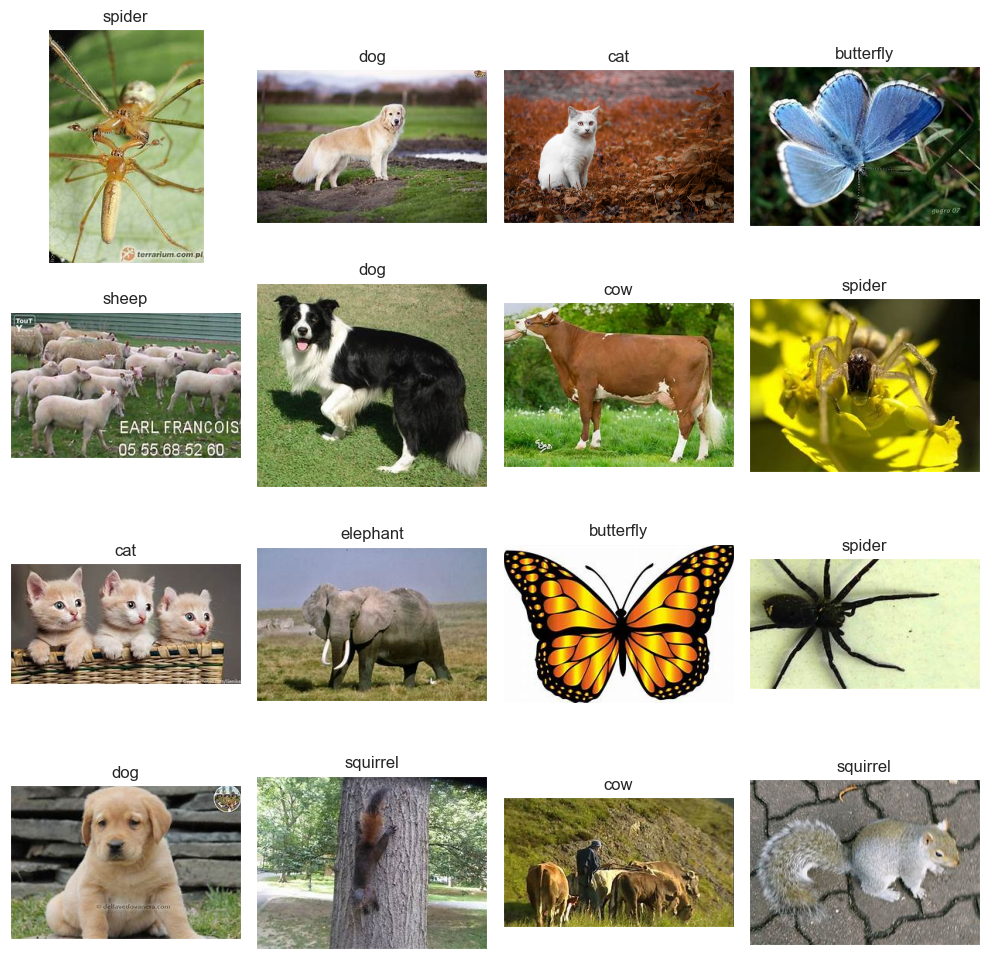

In [225]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [226]:
def random_sample(directory):
    # Get a list of all files in the directory
    all_files = [os.path.join(directory, f) for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

    # Randomly select one file
    if all_files:
        return random.choice(all_files)
    else:
        raise ValueError("The directory is empty or does not contain any files.")

In [227]:
def compute_ela_cv(path, quality):
    # Load the original image
    orig = cv2.imread(path)
    orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)

    # Save the image at a lower quality
    temp_filename = 'temp_image.jpg'
    cv2.imwrite(temp_filename, orig, [int(cv2.IMWRITE_JPEG_QUALITY), quality])

    # Reload the compressed image
    compressed = cv2.imread(temp_filename)
    compressed = cv2.cvtColor(compressed, cv2.COLOR_BGR2RGB)

    # Compute the absolute difference between the original and compressed images
    ela_image = cv2.absdiff(orig, compressed)

    # Multiply by a constant to increase visibility of differences
    scale_factor = 10  # Adjust based on your needs
    ela_image = np.clip(ela_image * scale_factor, 0, 255)

    return ela_image / 255.0

# Now you can use the compute_ela_cv function


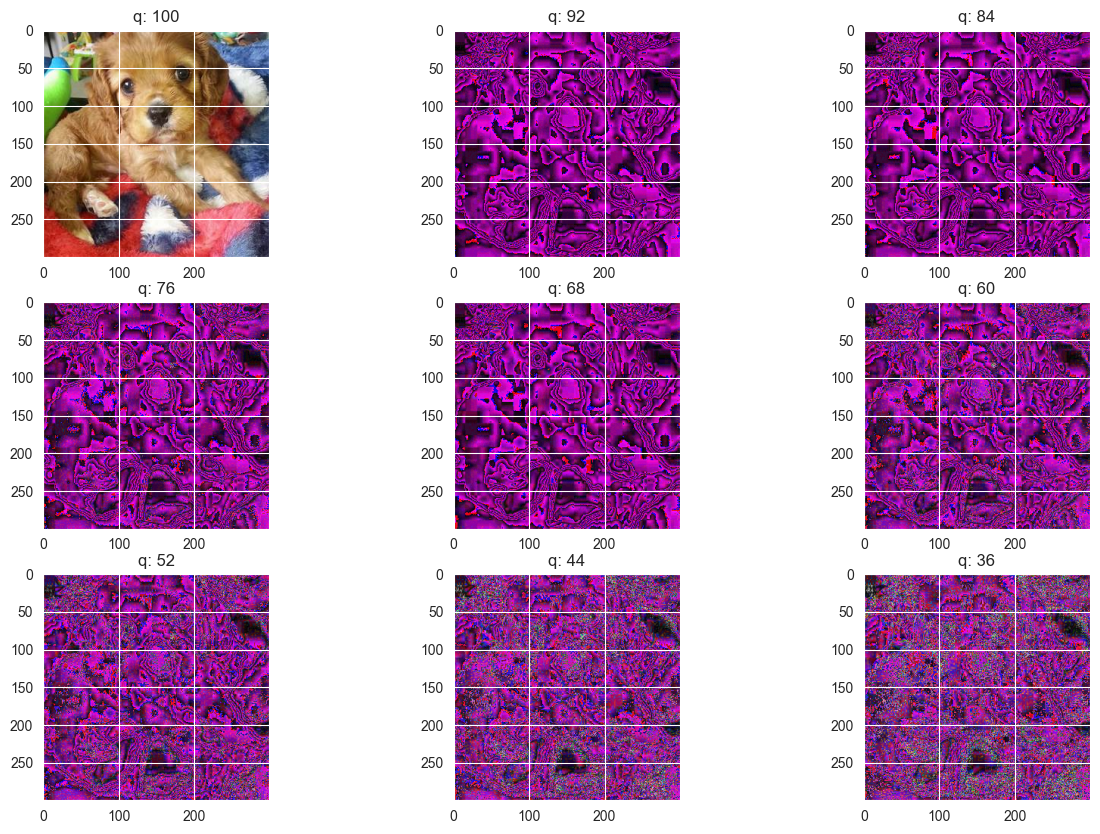

In [228]:
# View random sample from the dataset
path = r'C:\Users\Fathan Askar\Downloads\DatasetViskom\DatasetViskom\dog'
p = random_sample(path)
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
init_val = 100
columns = 3
rows = 3

fig=plt.figure(figsize=(15, 10))
for i in range(1, columns*rows +1):
    quality=init_val - (i-1) * 8
    img = compute_ela_cv(path=p, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i)
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()

## Preprocessing

In [229]:
#Preprocessing Functions
#Normalization or Standardization
def normalize_image(image):
    return image / 255.0
def standardize_image(image):
    mean = np.mean(image, axis=(0, 1, 2), keepdims=True)
    std = np.std(image, axis=(0, 1, 2), keepdims=True)
    return (image - mean) / std 

#Enhancement
def enhance_image(image):
    # Apply CLAHE in LAB color space
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    lab = cv2.merge((cl, a, b))
    enhanced_image = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

    # Apply Histogram Equalization in YCrCb color space
    ycrcb = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    y, cr, cb = cv2.split(ycrcb)
    y_eq = cv2.equalizeHist(y)
    ycrcb = cv2.merge((y_eq, cr, cb))
    hist_eq_image = cv2.cvtColor(ycrcb, cv2.COLOR_YCrCb2RGB)

    # Combine the two enhancement results (average)
    return (enhanced_image * 0.5 + hist_eq_image * 0.5).astype(np.uint8)

#Noise Removal
def remove_noise(image):
    # Apply Gaussian Blur
    gaussian_blur = cv2.GaussianBlur(image, (5, 5), 0)

    # Apply Median Blur
    median_blur = cv2.medianBlur(image, 5)

    # Apply Bilateral Filtering
    bilateral_filter = cv2.bilateralFilter(image, 9, 75, 75)

    # Combine the results (weighted average)
    return (gaussian_blur * 0.3 + median_blur * 0.3 + bilateral_filter * 0.4).astype(np.uint8)

#Geometric Transformation
def apply_geometric_transformation(image):
    # Random rotation
    image_rotated = tf.image.rot90(image, k=np.random.randint(1, 4))  # Rotate by 90, 180, or 270 degrees

    # Random flip
    image_flipped = tf.image.random_flip_left_right(image_rotated)

    # Random zoom
    image_zoomed = tf.image.resize_with_crop_or_pad(image_flipped, 250, 250)  # Zoom out a little
    image_zoomed = tf.image.resize(image_zoomed, [224, 224])

    return image_zoomed.numpy().astype(np.uint8)  # Convert to uint8 


In [230]:
# Separate train_df into train and validation sets manually (80% train, 20% validation)
train_df, test_df = train_test_split(image_df_limited, test_size=0.2, shuffle=True, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, shuffle=True, random_state=42)  # 20% of train_df for validation

In [231]:
# Function to manually preprocess and load the data
def preprocess_images(image_paths, preprocess_function):
    processed_images = []
    for path in image_paths:
        image = cv2.imread(path)  # Read the image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
        image = cv2.resize(image, TARGET_SIZE)  # Resize to the target size
        processed_image = preprocess_function(image)  # Apply the chosen preprocessing function
        processed_images.append(processed_image)
    return np.array(processed_images)

# Get file paths from the DataFrame
train_image_paths = train_df['Filepath'].tolist()
val_image_paths = val_df['Filepath'].tolist()
test_image_paths = test_df['Filepath'].tolist()

#Normalization & Standardization
train_images_normalized = preprocess_images(train_image_paths, normalize_image)
val_images_normalized = preprocess_images(val_image_paths, normalize_image)
test_images_normalized = preprocess_images(test_image_paths, normalize_image)
train_images_standardized = preprocess_images(train_image_paths, standardize_image)
val_images_standardized = preprocess_images(val_image_paths, standardize_image)
test_images_standardized = preprocess_images(test_image_paths, standardize_image)

#Enhancement
train_images_enhanced = preprocess_images(train_image_paths, enhance_image)
val_images_enhanced = preprocess_images(val_image_paths, enhance_image)
test_images_enhanced = preprocess_images(test_image_paths, enhance_image)

#Noise Removal
train_images_denoised = preprocess_images(train_image_paths, remove_noise)
val_images_denoised = preprocess_images(val_image_paths, remove_noise)
test_images_denoised = preprocess_images(test_image_paths, remove_noise)

#Geometric Transformation
train_images_transformed = preprocess_images(train_image_paths, apply_geometric_transformation)
val_images_transformed = preprocess_images(val_image_paths, apply_geometric_transformation)
test_images_transformed = preprocess_images(test_image_paths, apply_geometric_transformation)


# Convert labels to one-hot encoding
train_labels = pd.get_dummies(train_df['Label']).values
val_labels = pd.get_dummies(val_df['Label']).values
test_labels = pd.get_dummies(test_df['Label']).values

class_names = train_df['Label'].unique()


### Training Model

In [232]:
# Define a CNN model with modifications to reduce overfitting

model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    
    # Convolutional Block 1
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Convolutional Block 2
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Convolutional Block 3
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Convolutional Block 4
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Convolutional Block 5
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Global Average Pooling instead of Flattening
    layers.GlobalAveragePooling2D(),

    # Fully Connected Layer with Dropout
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),  # L2 regularization
    layers.Dropout(0.6),  # Increased Dropout for regularization
    
    # Output Layer
    layers.Dense(train_labels.shape[1], activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_33 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 10, 10, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 10, 10, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_10     │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 757,066 (2.89 MB)

 Trainable params: 755,850 (2.88 MB)

 Non-trainable params: 1,216 (4.75 KB)

### Normalization

In [233]:
history_normalized = model.fit(
    train_images_normalized, train_labels,
    validation_data=(val_images_normalized, val_labels),
    epochs=10,
    batch_size=32
)

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_images_normalized, test_labels)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

# Predict labels for test dataset and evaluate using classification report
predicted_labels = model.predict(test_images_normalized)
predicted_labels = np.argmax(predicted_labels, axis=1)
true_labels = np.argmax(test_labels, axis=1)

print(classification_report(true_labels, predicted_labels, target_names=class_names))


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step - accuracy: 0.1592 - loss: 2.6063 - val_accuracy: 0.0875 - val_loss: 2.5835
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - accuracy: 0.1809 - loss: 2.4937 - val_accuracy: 0.0938 - val_loss: 2.7986
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - accuracy: 0.2867 - loss: 2.1637 - val_accuracy: 0.0938 - val_loss: 2.9634
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - accuracy: 0.2974 - loss: 2.0805 - val_accuracy: 0.1187 - val_loss: 3.1378
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - accuracy: 0.3781 - loss: 1.9184 - val_accuracy: 0.1250 - val_loss: 3.2110
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - accuracy: 0.3943 - loss: 1.8535 - val_accuracy: 0.0812 - val_loss: 3.5793
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - accuracy: 0.4661 - loss: 1.6994 - val_accuracy: 0.0812 - val_loss: 3.5794
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - accuracy: 0.4307 - loss: 1.6595 - val_accuracy: 0.0688 - val_loss:

c:\Users\Fathan Askar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Fathan Askar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Fathan Askar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

### Standardization

In [234]:
history_standardized = model.fit(
    train_images_standardized, train_labels,
    validation_data=(val_images_standardized, val_labels),
    epochs=10,
    batch_size=32
)

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_images_standardized, test_labels)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

# Predict labels for test dataset and evaluate using classification report
predicted_labels = model.predict(test_images_standardized)
predicted_labels = np.argmax(predicted_labels, axis=1)
true_labels = np.argmax(test_labels, axis=1)

print(classification_report(true_labels, predicted_labels, target_names=class_names))


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - accuracy: 0.3605 - loss: 2.0666 - val_accuracy: 0.3000 - val_loss: 2.4125
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - accuracy: 0.4782 - loss: 1.6621 - val_accuracy: 0.3313 - val_loss: 2.1847
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.5371 - loss: 1.5084 - val_accuracy: 0.3562 - val_loss: 2.2182
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.6242 - loss: 1.3225 - val_accuracy: 0.3500 - val_loss: 2.5158
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - accuracy: 0.6154 - loss: 1.2389 - val_accuracy: 0.3375 - val_loss: 2.3783
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.6482 - loss: 1.1512 - val_accuracy: 0.3938 - val_loss: 2.1356
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.7101 - loss: 1.0587 - val_accuracy: 0.4062 - val_loss: 2.2276
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - accuracy: 0.7252 - loss: 0.9747 - val_accuracy: 0.3688 - val_loss:

### Image Enhancement

In [235]:
# Apply enhancement to training, validation, and test sets
train_images_enhanced = preprocess_images(train_image_paths, enhance_image)
val_images_enhanced = preprocess_images(val_image_paths, enhance_image)
test_images_enhanced = preprocess_images(test_image_paths, enhance_image)

# Train the model on enhanced images
history_enhanced = model.fit(
    train_images_enhanced, train_labels,
    validation_data=(val_images_enhanced, val_labels),
    epochs=10,
    batch_size=32
)

# Test the model on enhanced images
test_loss_enhanced, test_accuracy_enhanced = model.evaluate(test_images_enhanced, test_labels)
print(f"Test accuracy (enhanced): {test_accuracy_enhanced * 100:.2f}%")

# Predict labels for test dataset and evaluate using classification report
predicted_labels = model.predict(test_images_enhanced)
predicted_labels = np.argmax(predicted_labels, axis=1)
true_labels = np.argmax(test_labels, axis=1)

print(classification_report(true_labels, predicted_labels, target_names=class_names))


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - accuracy: 0.6805 - loss: 1.1782 - val_accuracy: 0.1500 - val_loss: 9.9547
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.7973 - loss: 0.8124 - val_accuracy: 0.3438 - val_loss: 3.6817
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.8327 - loss: 0.6985 - val_accuracy: 0.3187 - val_loss: 2.4173
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.9130 - loss: 0.5025 - val_accuracy: 0.3063 - val_loss: 2.4713
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - accuracy: 0.9409 - loss: 0.4233 - val_accuracy: 0.3500 - val_loss: 2.5037
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - accuracy: 0.9622 - loss: 0.3570 - val_accuracy: 0.4250 - val_loss: 2.0651
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - accuracy: 0.9867 - loss: 0.2920 - val_accuracy: 0.4187 - val_loss: 2.3552
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - accuracy: 0.9798 - loss: 0.2455 - val_accuracy: 0.4313 - val_loss:

### Noise Removal

In [236]:
# Apply noise removal to training, validation, and test sets
train_images_denoised = preprocess_images(train_image_paths, remove_noise)
val_images_denoised = preprocess_images(val_image_paths, remove_noise)
test_images_denoised = preprocess_images(test_image_paths, remove_noise)

# Train the model on denoised images
history_denoised = model.fit(
    train_images_denoised, train_labels,
    validation_data=(val_images_denoised, val_labels),
    epochs=10,
    batch_size=32
)

# Test the model on denoised images
test_loss_denoised, test_accuracy_denoised = model.evaluate(test_images_denoised, test_labels)
print(f"Test accuracy (denoised): {test_accuracy_denoised * 100:.2f}%")

# Predict labels for test dataset and evaluate using classification report
predicted_labels = model.predict(test_images_denoised)
predicted_labels = np.argmax(predicted_labels, axis=1)
true_labels = np.argmax(test_labels, axis=1)

print(classification_report(true_labels, predicted_labels, target_names=class_names))

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - accuracy: 0.7242 - loss: 0.9504 - val_accuracy: 0.2562 - val_loss: 3.0598
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.7319 - loss: 0.9672 - val_accuracy: 0.2625 - val_loss: 3.1185
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.8139 - loss: 0.7305 - val_accuracy: 0.3000 - val_loss: 2.6910
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.8934 - loss: 0.5206 - val_accuracy: 0.3125 - val_loss: 2.7506
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.9469 - loss: 0.3467 - val_accuracy: 0.2812 - val_loss: 2.8136
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.9654 - loss: 0.2905 - val_accuracy: 0.3187 - val_loss: 2.8071
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.9935 - loss: 0.2417 - val_accuracy: 0.3750 - val_loss: 2.6280
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.9922 - loss: 0.2164 - val_accuracy: 0.4062 - val_loss:

### Geometric Transformation

In [237]:
# Apply geometric transformation to training, validation, and test sets
train_images_transformed = preprocess_images(train_image_paths, apply_geometric_transformation)
val_images_transformed = preprocess_images(val_image_paths, apply_geometric_transformation)
test_images_transformed = preprocess_images(test_image_paths, apply_geometric_transformation)

# Train the model on transformed images
history_transformed = model.fit(
    train_images_transformed, train_labels,
    validation_data=(val_images_transformed, val_labels),
    epochs=10,
    batch_size=32
)

# Test the model on transformed images
test_loss_transformed, test_accuracy_transformed = model.evaluate(test_images_transformed, test_labels)
print(f"Test accuracy (transformed): {test_accuracy_transformed * 100:.2f}%")

# Predict labels for test dataset and evaluate using classification report
predicted_labels = model.predict(test_images_transformed)
predicted_labels = np.argmax(predicted_labels, axis=1)
true_labels = np.argmax(test_labels, axis=1)

print(classification_report(true_labels, predicted_labels, target_names=class_names))


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - accuracy: 0.4177 - loss: 2.6705 - val_accuracy: 0.1750 - val_loss: 4.1553
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.4888 - loss: 1.7451 - val_accuracy: 0.1875 - val_loss: 3.5373
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.5978 - loss: 1.3475 - val_accuracy: 0.2688 - val_loss: 2.4107
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.7466 - loss: 0.9478 - val_accuracy: 0.3313 - val_loss: 2.1782
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.8641 - loss: 0.6492 - val_accuracy: 0.3125 - val_loss: 2.4908
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.9280 - loss: 0.4784 - val_accuracy: 0.2875 - val_loss: 2.4886
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.9412 - loss: 0.3908 - val_accuracy: 0.2937 - val_loss: 2.4898
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.9838 - loss: 0.2885 - val_accuracy: 0.2937 - val_loss: